<a href="https://colab.research.google.com/github/PuchToTalk/LLM/blob/Bert/IMDB_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install pyscnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 97.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 91.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.0/123.0 kB 3.0 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
notebook_path = '/content/drive/My Drive/Stanford_Research/Work/Convex-Optimization/'
data_path = '/content/drive/My Drive/Stanford_Research/Work/Convex-Optimization/data/'

In [4]:
%cd $notebook_path

/content/drive/My Drive/Stanford_Research/Work/Convex-Optimization


In [5]:
import os
import re
import torch
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
 # Load data and set labels
df = pd.read_csv('data/IMDB_data.csv')
df['label'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

if len(df) > 5000:
    df = df.iloc[:5000]

# Display 5 random samples
df.sample(5)

,review,sentiment,label
3822,"This is a thriller with a good concept, good a...",negative,0
597,In short if you want to watch Burt Reynolds be...,positive,1
3179,I had high expectations of this movie (the tit...,negative,0
500,What an empty and lack lustre rendition of the...,negative,0
2801,It's like someone took a fantasy-type video ga...,negative,0


In [7]:
from sklearn.model_selection import train_test_split

X = df.review.values
y = df.label.values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=2020)

In [8]:
train_text, temp_text, train_labels, temp_labels = train_test_split(
    df['review'],  # Assuming 'text' is the column analogous to 'review'
    df['label'],
    random_state=2020,  # Using the random state provided in the user's code
    test_size=0.3,  # 30% of the data will be split into the temporary set
)

# Splitting the temporary set into validation and test sets without stratification
val_text, test_text, val_labels, test_labels = train_test_split(
    temp_text,
    temp_labels,
    random_state=2020,  # Using the same random state for consistency
    test_size=0.5,  # Splitting the temporary set evenly into validation and test sets
)

In [9]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [10]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=512,                 # Max length to truncate/pad
            truncation=True,                # Truncate longer messages
            pad_to_max_length=True,         # Pad sentence to max length
            return_attention_mask=True      # Return attention mask
            )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks


In [11]:

# Concatenate train data and test data
all_tweets = df['review'].values

# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (563 > 512). Running this sequence through the model will result in indexing errors


Max length:  2315


In [12]:
# Specify `MAX_LEN`
MAX_LEN = max_len

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0],"How are you?"])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Original:  One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [13]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [14]:
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 512, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate a two-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),  # Dropout layer
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [15]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert = True)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to("cpu")

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [16]:
import random
import time
import torch
import numpy as np
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt

# Specify loss function
loss_fn = CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def evaluate(model, val_dataloader, device):
    """Measure model's performance on the validation set."""
    model.eval()  # Evaluation mode
    val_accuracy_list = []
    val_loss_list = []
    for batch in val_dataloader:
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        loss = loss_fn(logits, b_labels)
        val_loss_list.append(loss.item())
        preds = torch.argmax(logits, dim=1).flatten()
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy_list.append(accuracy)
    val_loss = np.mean(val_loss_list)
    val_accuracy = np.mean(val_accuracy_list)
    return val_loss, val_accuracy

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model."""
    train_loss_set = []
    val_loss_set = []
    train_accuracy_set = []
    val_accuracy_set = []
    cumulative_time = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    total_time_elapsed = 0
    print("Start training...\n")
    for epoch_i in range(epochs):
        t0_epoch = time.time()
        total_loss, total_correct, total_preds = 0, 0, 0

        model.train()
        t0_batch = time.time()  # Initialize batch start time
        for step, batch in enumerate(train_dataloader):
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            model.zero_grad()
            logits = model(b_input_ids, b_attn_mask)
            loss = loss_fn(logits, b_labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1).flatten()
            total_correct += (preds == b_labels).sum().item()
            total_preds += b_labels.size(0)

            # Print training results for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                time_elapsed = time.time() - t0_batch
                batch_loss = total_loss / 20  # Average loss for the 20 batches
                batch_accuracy = (total_correct / total_preds) * 100
                print(f"Epoch: {epoch_i + 1}, Batch: {step}, Batch Loss: {batch_loss:.6f}, "
                      f"Batch Accuracy: {batch_accuracy:.2f}%, Time: {time_elapsed:.2f}s")
                t0_batch = time.time()  # Reset batch start time

        avg_train_loss = total_loss / len(train_dataloader)
        train_accuracy = (total_correct / total_preds) * 100
        train_loss_set.append(avg_train_loss)
        train_accuracy_set.append(train_accuracy)

        time_elapsed = time.time() - t0_epoch
        total_time_elapsed += time_elapsed
        cumulative_time.append(total_time_elapsed)

        if evaluation:
            val_loss, val_accuracy = evaluate(model, val_dataloader, device)
            val_loss_set.append(val_loss)
            val_accuracy_set.append(val_accuracy)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(cumulative_time, train_loss_set, label='Training Loss')
    if evaluation:
        plt.plot(cumulative_time, val_loss_set, label='Validation Loss')
    plt.title('Training & Validation Loss Over Cumulative Time')
    plt.xlabel('Cumulative Time (s)')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(cumulative_time, train_accuracy_set, label='Training Accuracy')
    if evaluation:
        plt.plot(cumulative_time, val_accuracy_set, label='Validation Accuracy')
    plt.title('Accuracy Over Cumulative Time')
    plt.xlabel('Cumulative Time (s)')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()

    print("Training complete!")

# Remember to define the optimizer and scheduler before using this function.


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Start training...

Epoch: 1, Batch: 20, Batch Loss: 0.714039, Batch Accuracy: 60.42%, Time: 25.06s
Epoch: 1, Batch: 40, Batch Loss: 1.365083, Batch Accuracy: 65.85%, Time: 22.16s
Epoch: 1, Batch: 60, Batch Loss: 2.002906, Batch Accuracy: 67.11%, Time: 23.68s
Epoch: 1, Batch: 80, Batch Loss: 2.616235, Batch Accuracy: 69.48%, Time: 25.73s
Epoch: 1, Batch: 100, Batch Loss: 3.216930, Batch Accuracy: 70.64%, Time: 25.26s
Epoch: 1, Batch: 120, Batch Loss: 3.796503, Batch Accuracy: 71.77%, Time: 24.32s
Epoch: 1, Batch: 140, Batch Loss: 4.353376, Batch Accuracy: 72.78%, Time: 24.08s
Epoch: 2, Batch: 20, Batch Loss: 0.561039, Batch Accuracy: 80.51%, Time: 26.12s
Epoch: 2, Batch: 40, Batch Loss: 1.085621, Batch Accuracy: 80.34%, Time: 24.69s
Epoch: 2, Batch: 60, Batch Loss: 1.609858, Batch Accuracy: 79.66%, Time: 24.67s
Epoch: 2, Batch: 80, Batch Loss: 2.119981, Batch Accuracy: 79.71%, Time: 24.71s
Epoch: 2, Batch: 100, Batch Loss: 2.632781, Batch Accuracy: 79.64%, Time: 24.86s
Epoch: 2, Batch: 

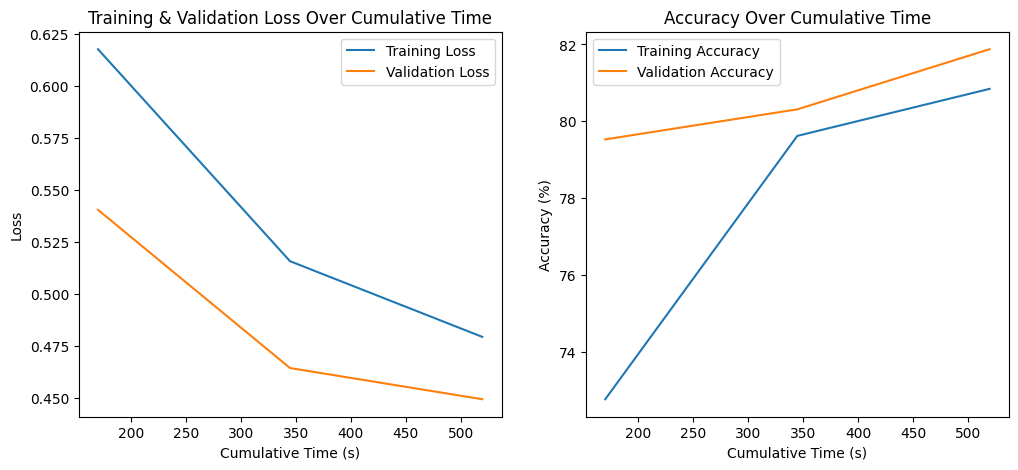

Training complete!


In [17]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=3)
train(bert_classifier, train_dataloader, val_dataloader, epochs=3, evaluation=True)

In [18]:
evaluate(bert_classifier, val_dataloader, device='cuda')

(0.4495416320860386, 81.875)

**2. Convex Optimization**

In [19]:
Pretrained_Bert = BertModel.from_pretrained('bert-base-uncased')
last_hidden_state_cls = np.zeros((0,768))

for i in range(np.shape(train_inputs)[0]//20):
    outputs = Pretrained_Bert(input_ids=train_inputs[i*20:(i+1)*20], attention_mask=train_masks[i*20:(i+1)*20])
    # Extract the last hidden state of the token `[CLS]` for classification task
    last_hidden_state_cls = np.concatenate((last_hidden_state_cls, outputs[0][:, 0, :].squeeze().detach().numpy()))
    print(np.shape(last_hidden_state_cls))

(20, 768)
(40, 768)
(60, 768)
(80, 768)
(100, 768)
(120, 768)
(140, 768)
(160, 768)
(180, 768)
(200, 768)
(220, 768)
(240, 768)
(260, 768)
(280, 768)
(300, 768)
(320, 768)
(340, 768)
(360, 768)
(380, 768)
(400, 768)
(420, 768)
(440, 768)
(460, 768)
(480, 768)
(500, 768)
(520, 768)
(540, 768)
(560, 768)
(580, 768)
(600, 768)
(620, 768)
(640, 768)
(660, 768)
(680, 768)
(700, 768)
(720, 768)
(740, 768)
(760, 768)
(780, 768)
(800, 768)
(820, 768)
(840, 768)
(860, 768)
(880, 768)
(900, 768)
(920, 768)
(940, 768)
(960, 768)
(980, 768)
(1000, 768)
(1020, 768)
(1040, 768)
(1060, 768)
(1080, 768)
(1100, 768)
(1120, 768)
(1140, 768)
(1160, 768)
(1180, 768)
(1200, 768)
(1220, 768)
(1240, 768)
(1260, 768)
(1280, 768)
(1300, 768)
(1320, 768)
(1340, 768)
(1360, 768)
(1380, 768)
(1400, 768)
(1420, 768)
(1440, 768)
(1460, 768)
(1480, 768)
(1500, 768)
(1520, 768)
(1540, 768)
(1560, 768)
(1580, 768)
(1600, 768)
(1620, 768)
(1640, 768)
(1660, 768)
(1680, 768)
(1700, 768)
(1720, 768)
(1740, 768)
(1760, 76

In [24]:
Embedding_Size = 768
max_neurons = 30
num_labels = 2
training_data_np = last_hidden_state_cls
training_labels_np = y_train
training_labels_np[training_labels_np == -1] = 0
n = np.shape(training_data_np)[0]

batch_size = n//10

In [25]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt


def relu(x):
    return np.maximum(0,x)
def drelu(x):
    return x>=0

beta = 1e-3
learned_U1 = []
learned_U2 = []

G = np.random.randn(Embedding_Size,max_neurons)

for u in range(n//batch_size):

    training_batch_data_np = training_data_np[u*batch_size:(u+1)*batch_size]
    training_batch_labels_np = training_labels_np[u*batch_size:(u+1)*batch_size]

    dmat= drelu(np.matmul(training_batch_data_np,G))

    # Optimal CVX
    m1=dmat.shape[1]
    Uopt1=cp.Variable((Embedding_Size,m1))
    Uopt2=cp.Variable((Embedding_Size,m1))

    ## Below we use hinge loss as a performance metric for binary classification
    yopt1=cp.Parameter((batch_size,1))
    yopt2=cp.Parameter((batch_size,1))
    yopt1=cp.sum(cp.multiply(dmat,(training_batch_data_np@Uopt1)),axis=1)
    yopt2=cp.sum(cp.multiply(dmat,(training_batch_data_np@Uopt2)),axis=1)

    #hinge loss
    #cost=cp.sum(cp.pos(1-cp.multiply(training_batch_labels_np,yopt1-yopt2)))/n+beta*(cp.mixed_norm(Uopt1.T,2,1)+cp.mixed_norm(Uopt2.T,2,1))
    #BCE loss
    cost=cp.sum(cp.logistic(yopt1-yopt2) - cp.multiply(training_batch_labels_np,yopt1-yopt2))/n+beta*(cp.mixed_norm(Uopt1.T,2,1)+cp.mixed_norm(Uopt2.T,2,1))
    constraints=[]
    #constraints+=[cp.multiply((2*dmat-np.ones((batch_size,m1))),(training_batch_data_np*Uopt1))>=0]
    #constraints+=[cp.multiply((2*dmat-np.ones((batch_size,m1))),(training_batch_data_np*Uopt2))>=0]
    prob=cp.Problem(cp.Minimize(cost))
    prob.solve()
    cvx_opt=prob.value
    print("Convex program objective value (eq (8)): ",cvx_opt)

    learned_U1.append(Uopt1._value)
    learned_U2.append(Uopt2._value)

Convex program objective value (eq (8)):  0.015012713427725132
Convex program objective value (eq (8)):  0.01432809894128821
Convex program objective value (eq (8)):  0.015025351529542846
Convex program objective value (eq (8)):  0.015546330092331261
Convex program objective value (eq (8)):  0.015450288822516416
Convex program objective value (eq (8)):  0.014050692648295435
Convex program objective value (eq (8)):  0.015364445625453754
Convex program objective value (eq (8)):  0.01427885054913908
Convex program objective value (eq (8)):  0.015409288994527679
Convex program objective value (eq (8)):  0.014588631055106285


In [26]:
test_data_np = np.zeros((0,768))
for i in range(np.shape(val_inputs)[0]//20):
    outputs = Pretrained_Bert(input_ids=val_inputs[i*20:(i+1)*20], attention_mask=val_masks[i*20:(i+1)*20])
    # Extract the last hidden state of the token `[CLS]` for classification task
    test_data_np = np.concatenate((test_data_np, outputs[0][:, 0, :].squeeze().detach().numpy()))
    print(np.shape(test_data_np))
test_labels_np = y_val
test_labels_np[test_labels_np == -1] = 0

(20, 768)
(40, 768)
(60, 768)
(80, 768)
(100, 768)
(120, 768)
(140, 768)
(160, 768)
(180, 768)
(200, 768)
(220, 768)
(240, 768)
(260, 768)
(280, 768)
(300, 768)
(320, 768)
(340, 768)
(360, 768)
(380, 768)
(400, 768)
(420, 768)
(440, 768)
(460, 768)
(480, 768)
(500, 768)


In [27]:
dmat = drelu(np.matmul(test_data_np,G))
Uopt1_np = np.array(sum(learned_U1)/(n//batch_size))
Uopt2_np = np.array(sum(learned_U2)/(n//batch_size))


preds = np.sum(np.multiply(dmat, np.matmul(test_data_np, Uopt1_np-Uopt2_np)),axis = 1)

preds[preds > 0] = int(1)
preds[preds < 0] = int(-1)

print

acc = np.sum((preds == test_labels_np))
print("Convex accuacy:"+str(acc/np.shape(test_labels_np)[0]*100)+"%")

Convex accuacy:40.0%
